# Generic pipeline for segmentation tests

This notebook demonstrates how a pretrained model can be used to perform semantic segmentation on a set of images and compute some statistics on the identified objects. The model used below is the pretrained [`Mask2FormerForUniversalSegmentation`](https://huggingface.co/docs/transformers/en/model_doc/mask2former) model from Huggingface, which is an implementation of the [`Mask2Former`](https://arxiv.org/abs/2112.01527) model from FAIR.

In [1]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
import numpy as np

# --------------------------------------
from rich import print as pp

# --------------------------------------
from streetscapes import conf
from streetscapes.models import MaskFormerVistasPanoptic

## Load a segmentation model

In this example, we instruct the model that all instances of `sky` and `water` should be treated as a single instance.

In [2]:
mfp = MaskFormerVistasPanoptic(labels_to_fuse={"sky", "water"})

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


Select a few images at random.

<span style="color:red;">Note</span>: please make sure that you download some images first (cf. `download_city_images.ipynb`).

In [3]:
image_dir = conf.OUTPUT_DIR / "images"
images = list(np.random.choice(list(image_dir.glob("*.jpeg")), 2, replace=False))
[image.name for image in images]

['258580789336277.jpeg', '462328211494371.jpeg']

Choose one of those as a test image.

In [4]:
test_image = images[0].name

## Segment the images

In [5]:
segmentations = mfp.segment(images)

Streetscapes | 2025-02-10@11:13:26 | Segmenting images...


100%|██████████| 2/2 [00:09<00:00,  4.82s/it]


Show the segmentation result for our test image.

In [6]:
segmentations[test_image]['segmentation']

tensor([[ 7,  7,  7,  ...,  2,  2,  2],
        [ 7,  7,  7,  ...,  2,  2,  2],
        [ 7,  7,  7,  ...,  2,  2,  2],
        ...,
        [12, 12, 12,  ...,  2,  2,  2],
        [12, 12, 12,  ...,  2,  2,  2],
        [12, 12, 12,  ...,  2,  2,  2]], dtype=torch.int32)

## Compute the statistics

The result is a dictionary of statistics for each segment of each category type.

In [7]:
stats = mfp.compute_statistics(images, segmentations)

Streetscapes | 2025-02-10@11:13:36 | Computing statistics...


100%|██████████| 2/2 [00:30<00:00, 15.04s/it]


Show a subset of the statistics

In [8]:
pp(stats[test_image]['building'])

[
    {
        'colour': {
            'median': [0.3333333333333333, 0.3176470588235294, 0.30980392156862746],
            'mode': [0.34901960784313724, 0.0196078431372549, 0.3215686274509804],
            'mean': [0.31859363251923517, 0.32375017429099207, 0.32507727322143276],
            'sd': [0.18742897400194627, 0.19990862104772725, 0.205720505078857]
        },
        'hue': {
            'median': 0.5683760683760684,
            'mode': 0.6666666666666666,
            'mean': 0.45328972561474734,
            'sd': 0.2687209273784357
        },
        'saturation': {
            'median': 0.16083916083916086,
            'mode': 0.0,
            'mean': 0.1942441504589487,
            'sd': 0.15613434666381332
        },
        'value': {
            'median': 0.34509803921568627,
            'mode': 0.34901960784313724,
            'mean': 0.3565572955012795,
            'sd': 0.20963484102732055
        },
        'area': 0.6391773223876953
    }
]

### Visualise the the segmentation results

Select a few categories that we might be interested in.

In [9]:
categories = {"sky", "building", "road", "vegetation", "water", "sidewalk", "person", "car", "bicyclist"}

Display the segmentation results.

Streetscapes | 2025-02-10@11:14:06 | Segmenting images...


100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


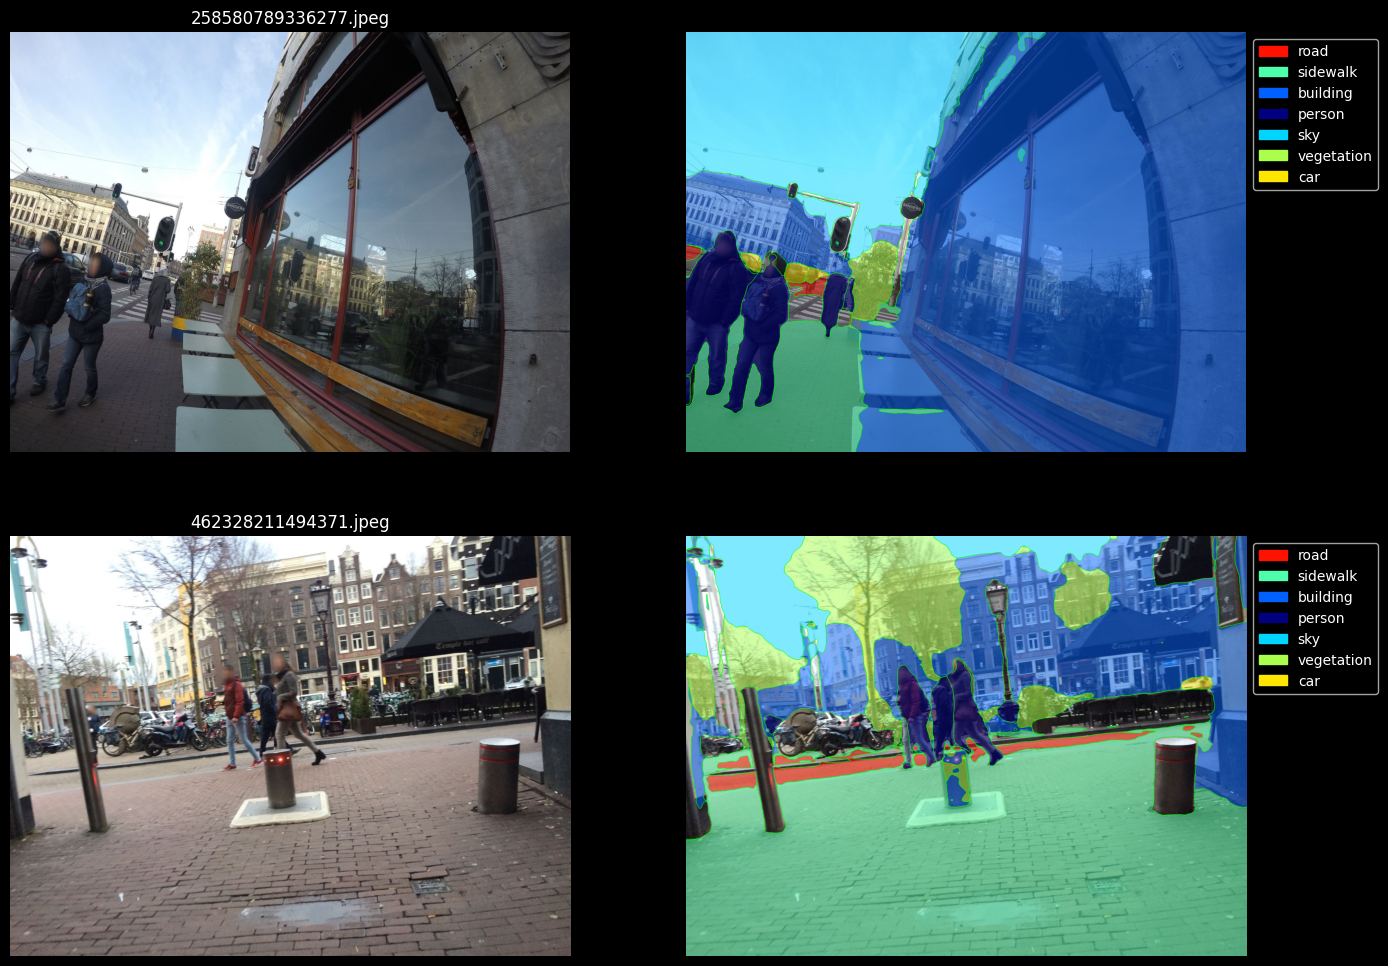

In [10]:
fig, ax, image_stats = mfp.visualise_segmentation(images, categories, stats=stats)

Show a subset of the statistics for one of the categories that we are interested in.

In [11]:
pp(image_stats[test_image]['building'])

[
    {
        'colour': {
            'median': [0.3333333333333333, 0.3176470588235294, 0.30980392156862746],
            'mode': [0.34901960784313724, 0.0196078431372549, 0.3215686274509804],
            'mean': [0.31859363251923517, 0.32375017429099207, 0.32507727322143276],
            'sd': [0.18742897400194627, 0.19990862104772725, 0.205720505078857]
        },
        'hue': {
            'median': 0.5683760683760684,
            'mode': 0.6666666666666666,
            'mean': 0.45328972561474734,
            'sd': 0.2687209273784357
        },
        'saturation': {
            'median': 0.16083916083916086,
            'mode': 0.0,
            'mean': 0.1942441504589487,
            'sd': 0.15613434666381332
        },
        'value': {
            'median': 0.34509803921568627,
            'mode': 0.34901960784313724,
            'mean': 0.3565572955012795,
            'sd': 0.20963484102732055
        },
        'area': 0.6391773223876953
    }
]

## Process images from a subset

The segmentation model also provides a convenience method to process all the images in a subset of the `streetscapes` dataset.

Load a subset file.

In [12]:
amsterdam_side = conf.OUTPUT_DIR / "amsterdam_side.csv"

Select a file to save the statistics to.

In [13]:
out_file_path = amsterdam_side.with_name(f"{amsterdam_side.stem}-stats.parquet")

Process all images in the dataset and save the statistics to a Parquet file in one go.

In [14]:
(ds_images, ds_segmented, ds_stats) = mfp.segment_from_dataset(amsterdam_side, sample=5, out_file_path=out_file_path)

Streetscapes | 2025-02-10@11:14:20 | Segmenting images...


100%|██████████| 5/5 [00:23<00:00,  4.64s/it]

Streetscapes | 2025-02-10@11:14:43 | Computing statistics...



100%|██████████| 5/5 [01:10<00:00, 14.14s/it]


The statistics can be loaded back into a dictionary format.

In [15]:
loaded_stats = mfp.load_stats(out_file_path)

Pick an image file and check that the computed statistics and the loaded statistics are identical

In [16]:
test_image = list(ds_images.keys())[0]

A sample item from the computed statistics

In [17]:
pp(ds_stats[test_image]['building'])

[
    {
        'colour': {
            'median': [0.21176470588235294, 0.21176470588235294, 0.20784313725490197],
            'mode': [0.3254901960784314, 0.3411764705882353, 0.34901960784313724],
            'mean': [0.21974555055593037, 0.22475859543672996, 0.22313591510990696],
            'sd': [0.13864892837698778, 0.14119379511929517, 0.14504074661313066]
        },
        'hue': {
            'median': 0.4166666666666667,
            'mode': 0.5714285714285715,
            'mean': 0.36809634729160534,
            'sd': 0.23990448204254036
        },
        'saturation': {
            'median': 0.11538461538461552,
            'mode': 0.0,
            'mean': 0.16999311280926638,
            'sd': 0.1652467990388771
        },
        'value': {
            'median': 0.22745098039215686,
            'mode': 0.3529411764705882,
            'mean': 0.23681525316477545,
            'sd': 0.14411903148969146
        },
        'area': 0.1481304168701172
    }
]

The same item from the loaded statistics

In [18]:
pp(loaded_stats[test_image]["building"])

[
    {
        'colour': {
            'median': [0.21176470588235294, 0.21176470588235294, 0.20784313725490197],
            'mode': [0.3254901960784314, 0.3411764705882353, 0.34901960784313724],
            'mean': [0.21974555055593037, 0.22475859543672996, 0.22313591510990696],
            'sd': [0.13864892837698778, 0.14119379511929517, 0.14504074661313066]
        },
        'hue': {
            'median': 0.4166666666666667,
            'mode': 0.5714285714285715,
            'mean': 0.36809634729160534,
            'sd': 0.23990448204254036
        },
        'saturation': {
            'median': 0.11538461538461552,
            'mode': 0.0,
            'mean': 0.16999311280926638,
            'sd': 0.1652467990388771
        },
        'value': {
            'median': 0.22745098039215686,
            'mode': 0.3529411764705882,
            'mean': 0.23681525316477545,
            'sd': 0.14411903148969146
        },
        'area': 0.1481304168701172
    }
]